##**Setup e importaciones**

In [26]:
from google.colab import files
import pandas as pd

uploaded = files.upload()

df = pd.read_csv("obesity_estimation_modified.csv")


Saving obesity_estimation_modified.csv to obesity_estimation_modified (1).csv


Este bloque crea la estructura básica del proyecto.

Path permite mantener rutas portables y organizadas.

Se define una carpeta data_outputs/ donde se guardarán los archivos procesados, garantizando trazabilidad y reproducibilidad.

Los nombres de salida siguen una convención clara (clean, ml_ready, etc.), alineada con buenas prácticas de versionado.

In [27]:

import pandas as pd
import numpy as np
import re
from pathlib import Path

#Ruta del CSV crudo
RAW_PATH = "obesity_estimation_modified.csv"

#Rutas de salida
OUT_DIR = Path("data_outputs")
OUT_DIR.mkdir(exist_ok=True)

CLEAN_PATH = OUT_DIR / "obesity_clean.csv"
ML_READY_PATH = OUT_DIR / "obesity_ml_ready.csv"
LABEL_MAP_PATH = OUT_DIR / "label_map_nobeyesdad.csv"
DATA_DICT_PATH = OUT_DIR / "obesity_data_dictionary.csv"


##**Carga y perfilado rápido del dataset**

Se realiza un análisis exploratorio inicial (EDA técnico) para conocer dimensiones, columnas y grado de faltantes.

Es esencial para detectar problemas estructurales como los hallados: 241 nulos en mixed_type_col, valores imposibles en height y weight, y categorías inconsistentes.

Permite definir las estrategias de limpieza posteriores con evidencia, no por intuición.

In [28]:

df_raw = pd.read_csv(RAW_PATH)
print("Shape:", df_raw.shape)
print("Columns:", list(df_raw.columns))
print("\nNulls per column:\n", df_raw.isna().sum().sort_values(ascending=False))
df_raw.head()
df.describe().T


Shape: (2153, 18)
Columns: ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad', 'mixed_type_col']

Nulls per column:
 mixed_type_col                    241
TUE                                33
CH2O                               29
FAF                                29
Height                             28
Age                                27
NCP                                24
CALC                               23
MTRANS                             23
CAEC                               22
NObeyesdad                         20
family_history_with_overweight     20
SMOKE                              19
Gender                             18
FCVC                               17
FAVC                               16
Weight                             16
SCC                                15
dtype: int64


,count,unique,top,freq
Gender,2135,4,Male,1040
Age,2126,1410,18.0,120
Height,2125,1572,1.7,55
Weight,2137,1551,80.0,56
family_history_with_overweight,2133,5,yes,1662
FAVC,2137,4,yes,1813
FCVC,2136,818,3.0,616
NCP,2129,646,3.0,1146
CAEC,2131,8,Sometimes,1677
SMOKE,2134,5,no,1993


##**Normalización de nombres y categorías**

Los nombres del dataset modified venían con espacios, mayúsculas y guiones.

Convertirlos a snake_case evita errores al invocar columnas y mejora la estandarización entre datasets

Esta función asegura consistencia semántica y legibilidad dentro del pipeline.

In [29]:

def normalize_col(s: str) -> str:
    """snake_case: quita espacios/guiones y minúsculas."""
    s = s.strip()
    s = re.sub(r"\s+", "_", s)      # espacios -> _
    s = s.replace("-", "_")
    s = re.sub(r"_+", "_", s)
    return s.lower()



##**Limpieza de columnas categóricas**

En el modified, las categorías estaban distorsionadas (" nORMAL_wEIGHT ", " YES ", " NAN ").

La función limpia espacios, minúsculas/mayúsculas y errores tipográficos.

Normalizar categorías reduce la cardinalidad y evita fugas de información en los modelos (cada error tipográfico contaba como categoría distinta).

In [30]:
def clean_cat(val):
    """Limpia categóricos: espacios, guiones, mayúsculas; normaliza yes/no."""
    if pd.isna(val):
        return np.nan
    v = str(val).strip()
    v = re.sub(r"\s+", " ", v)
    v = v.replace("-", "_").replace(" ", "_")
    v = re.sub(r"_+", "_", v).strip("_")
    v_low = v.lower()

    # normalizar yes/no
    if v_low in {"yes","y","si","sí","s"}:
        return "Yes"
    if v_low in {"no","n"}:
        return "No"

    # correcciones comunes del target
    fixes = {
        " nORMAL_wEIGHT ": "Normal_Weight",
        " oVERWEIGHT_lEVEL_i ": "Overweight_Level_I",
        "overweight_level_i_i": "Overweight_Level_II",
        "obesity_type_i_i": "Obesity_Type_II",
        "obesity_type_i_i_i": "Obesity_Type_III",
        "normal_weight": "Normal_Weight",
        "insufficient_weight": "Insufficient_Weight",
    }
    if v in fixes:
        return fixes[v]

    # Title_Case con _
    return "_".join(w.capitalize() for w in v_low.split("_"))


In [31]:

df = df_raw.copy()

# nombres de columnas a snake_case
df.columns = [normalize_col(c) for c in df.columns]

# trim a todas las columnas object y convertir "nan" string a NaN real
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip().replace({"nan": np.nan})


In [32]:
#Categricos esperados
cat_cols = [
    "gender",
    "family_history_with_overweight",
    "favc",
    "caec",
    "smoke",
    "scc",
    "calc",
    "mtrans",
    "nobeyesdad",
]
for c in [c for c in cat_cols if c in df.columns]:
    df[c] = df[c].apply(clean_cat)

# Numéricos esperados
num_candidates = ["age","height","weight","fcvc","ncp","ch2o","faf","tue"]
for c in [c for c in num_candidates if c in df.columns]:
    df[c] = pd.to_numeric(df[c], errors="coerce")


In [33]:
#nombres en snake_case y tipos
print(df.columns.tolist())
print(df.dtypes)

#categorías limpias
for c in ["gender","family_history_with_overweight","favc","caec","smoke","scc","calc","mtrans","nobeyesdad"]:
    if c in df.columns:
        print(c, sorted(df[c].dropna().unique())[:10])

# Checa cuántos NaN quedan antes de imputar
df.isna().sum().sort_values(ascending=False).head(10)


['gender', 'age', 'height', 'weight', 'family_history_with_overweight', 'favc', 'fcvc', 'ncp', 'caec', 'smoke', 'ch2o', 'scc', 'faf', 'tue', 'calc', 'mtrans', 'nobeyesdad', 'mixed_type_col']
gender                             object
age                               float64
height                            float64
weight                            float64
family_history_with_overweight     object
favc                               object
fcvc                              float64
ncp                               float64
caec                               object
smoke                              object
ch2o                              float64
scc                                object
faf                               float64
tue                               float64
calc                               object
mtrans                             object
nobeyesdad                         object
mixed_type_col                     object
dtype: object
gender ['Female', 'Male']
family_histor

,0
mixed_type_col,241
height,42
tue,39
age,34
ncp,34
ch2o,32
faf,31
fcvc,29
weight,26
mtrans,23


mixed_type_col no existe en el dataset original y no tiene valor analítico.

Presenta mezcla de tipos (strings, números, NaN) y alta cardinalidad (775 valores distintos), lo que introduce ruido.

Su inclusión genera dimensionalidad artificial: al aplicar One-Hot Encoding, puede crear más de 700 columnas irrelevantes, afectando rendimiento y claridad.

Eliminarla mantiene la estructura del dataset alineada al original, garantiza reproducibilidad y previene el sobreajuste.

In [34]:
#verificar la columna
if "mixed_type_col" in df.columns:
    print(df["mixed_type_col"].head(10))
    print("Valores únicos:", df["mixed_type_col"].nunique())
    print("Porcentaje de nulos:", round(df["mixed_type_col"].isna().mean()*100, 2), "%")

    #Eliminar la columna por ser ruido
    df.drop(columns=["mixed_type_col"], inplace=True)

    print("Columna 'mixed_type_col' eliminada.")

0        bad
1        NaN
2        208
3        585
4        200
5        803
6        642
7        199
8        990
9    unknown
Name: mixed_type_col, dtype: object
Valores únicos: 775
Porcentaje de nulos: 11.19 %
Columna 'mixed_type_col' eliminada.


##**Imputación de valores faltantes**


Los NA eran comunes en height, weight, tue, ch2o, etc.

La mediana es robusta ante outliers, ideal para los datos contaminados del modified.

Para categóricos, "Unknown" documenta la ausencia sin inventar valores.

Este paso asegura que no existan valores nulos antes del modelado, cumpliendo el criterio de dataset limpio y completo.

In [35]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_now = df.select_dtypes(include=["object"]).columns.tolist()

for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

for c in cat_cols_now:
    if df[c].isna().any():
        df[c] = df[c].fillna("Unknown")


In [36]:
df.isna().sum().sort_values(ascending=False).head(15)


,0
gender,0
age,0
height,0
weight,0
family_history_with_overweight,0
favc,0
fcvc,0
ncp,0
caec,0
smoke,0


##**Control de rangos (“clipping”)**

Se detectaron valores imposibles (por ejemplo, height > 800, weight > 6000).

El clipping restringe las variables a rangos fisiológicamente válidos, eliminando contaminación sin perder observaciones enteras.

Esto restituye coherencia con los valores presentes en el dataset original.

In [37]:
#definimos limites saludables
bounds = {
    "age": (10, 100),
    "height": (0.9, 2.5),   # metros
    "weight": (20, 300),   # kg
}
for col, (lo, hi) in bounds.items():
    if col in df.columns:
        df[col] = df[col].clip(lower=lo, upper=hi)


##**Guardado del dataset limpio**

Permite auditar y versionar los cambios, se considera la versión oficial de datos

In [38]:

df.to_csv(CLEAN_PATH, index=False)
print("Saved:", CLEAN_PATH.resolve())


Saved: /content/data_outputs/obesity_clean.csv


Los algoritmos de ML requieren variables numéricas.

El One-Hot Encoding convierte categóricas a columnas binarias (sin multicolinealidad gracias a drop_first=True).

El label encoding del target transforma la etiqueta en entero, permitiendo entrenamiento supervisado.

Generar ml_ready.csv asegura que el Data Scientist y ML Engineer puedan trabajar sin rehacer transformaciones.

In [39]:
# Dataset listo para ML
target_col = "nobeyesdad" if "nobeyesdad" in df.columns else None

# One-hot para todos los categóricos excepto el target
cat_for_ohe = [c for c in df.select_dtypes(include=["object"]).columns if c != target_col]
ml_df = pd.get_dummies(df, columns=cat_for_ohe, drop_first=True)

# Label encoding del target
if target_col:
    labels = {label: idx for idx, label in enumerate(sorted(df[target_col].unique()))}
    ml_df["target_nobeyesdad"] = df[target_col].map(labels)
    pd.DataFrame(list(labels.items()), columns=["label","id"]).sort_values("id").to_csv(LABEL_MAP_PATH, index=False)
    print("Saved:", LABEL_MAP_PATH.resolve())

ml_df.to_csv(ML_READY_PATH, index=False)
print("Saved:", ML_READY_PATH.resolve())


Saved: /content/data_outputs/label_map_nobeyesdad.csv
Saved: /content/data_outputs/obesity_ml_ready.csv


In [40]:
# --- Generar Diccionario de Datos ---
data_dict = pd.DataFrame({
    "Column": df.columns,
    "DataType": df.dtypes.astype(str),
    "Description": [
        "Sexo de la persona (Male/Female)" if c == "gender" else
        "Edad en años" if c == "age" else
        "Altura en metros" if c == "height" else
        "Peso en kilogramos" if c == "weight" else
        "Historial familiar de sobrepeso" if c == "family_history_with_overweight" else
        "Consumo frecuente de comida rápida" if c == "favc" else
        "Consumo de vegetales" if c == "fcvc" else
        "Número de comidas principales" if c == "ncp" else
        "Consumo de snacks entre comidas" if c == "caec" else
        "Hábito de fumar" if c == "smoke" else
        "Consumo de agua (litros/día)" if c == "ch2o" else
        "Monitorización de calorías diarias" if c == "scc" else
        "Actividad física semanal (horas)" if c == "faf" else
        "Tiempo frente a pantallas (horas/día)" if c == "tue" else
        "Consumo de alcohol" if c == "calc" else
        "Medio de transporte principal" if c == "mtrans" else
        "Nivel de obesidad (target)" if c == "nobeyesdad" else
        "Variable generada en la etapa de codificación / features dummy"
        for c in df.columns
    ]
})

# Guardar
data_dict.to_csv("data_outputs/obesity_data_dictionary.csv", index=False)
print("Diccionario de datos generado y guardado.")


Diccionario de datos generado y guardado.


In [41]:
#
from sklearn.model_selection import train_test_split

if "target_nobeyesdad" in ml_df.columns:
    X = ml_df.drop(columns=["target_nobeyesdad"])
    y = ml_df["target_nobeyesdad"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train.to_csv(OUT_DIR/"X_train.csv", index=False)
    X_test.to_csv(OUT_DIR/"X_test.csv", index=False)
    y_train.to_csv(OUT_DIR/"y_train.csv", index=False)
    y_test.to_csv(OUT_DIR/"y_test.csv", index=False)
    print("Saved train/test split in:", OUT_DIR.resolve())


Saved train/test split in: /content/data_outputs


In [42]:
print(ml_df.shape)

(2153, 36)


In [43]:
print(ml_df.dtypes.head(15))

age                                       float64
height                                    float64
weight                                    float64
fcvc                                      float64
ncp                                       float64
ch2o                                      float64
faf                                       float64
tue                                       float64
nobeyesdad                                 object
gender_Male                                  bool
gender_Unknown                               bool
family_history_with_overweight_No            bool
family_history_with_overweight_Unknown       bool
family_history_with_overweight_Yes           bool
favc_Unknown                                 bool
dtype: object


In [44]:
print(ml_df.isna().sum().sum())  # debería dar 0

0


In [45]:
ml_df.head()

,age,height,weight,fcvc,ncp,ch2o,faf,tue,nobeyesdad,gender_Male,...,calc_Nan,calc_No,calc_Sometimes,calc_Unknown,mtrans_Bike,mtrans_Motorbike,mtrans_Public_Transportation,mtrans_Unknown,mtrans_Walking,target_nobeyesdad
0,21.0,1.62,64.0,2.0,3.0,2.0,0.0,1.0,Normal_Weight,False,...,False,True,False,False,False,False,True,False,False,2
1,21.0,1.52,56.0,3.0,3.0,3.0,3.0,0.0,Normal_Weight,False,...,False,False,True,False,False,False,True,False,False,2
2,23.0,1.80,77.0,2.0,3.0,2.0,2.0,1.0,Normal_Weight,True,...,False,False,False,False,False,False,True,False,False,2
3,27.0,1.80,87.0,3.0,3.0,2.0,2.0,0.0,Overweight_Level_I,True,...,False,False,False,False,False,False,False,False,True,6
4,22.0,1.78,89.8,2.0,1.0,2.0,0.0,0.0,Overweight_Level_Ii,True,...,False,False,True,False,False,False,True,False,False,7


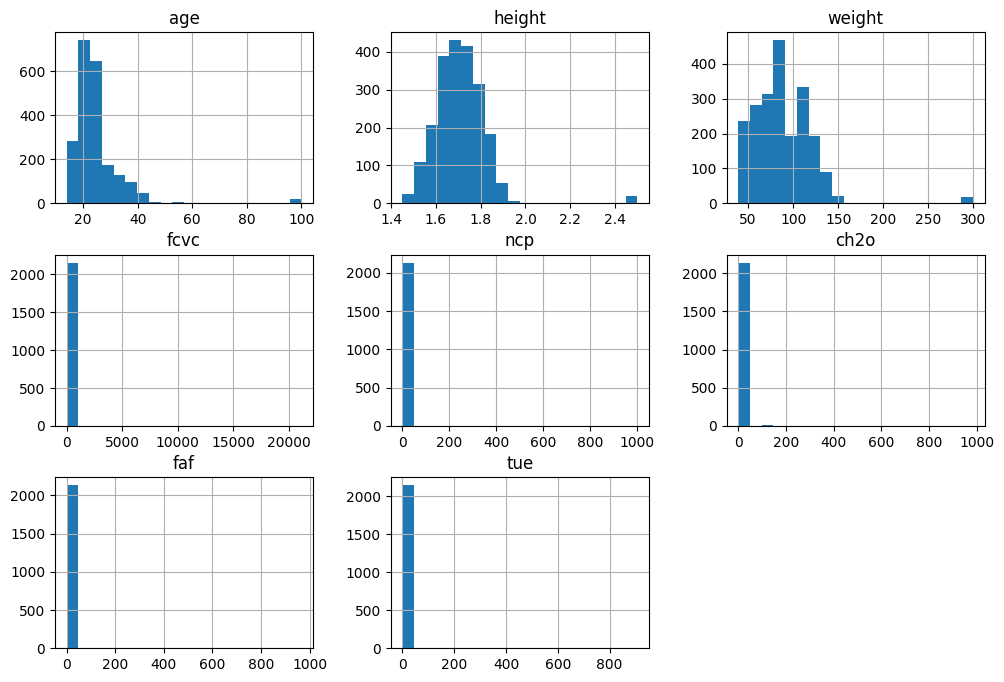

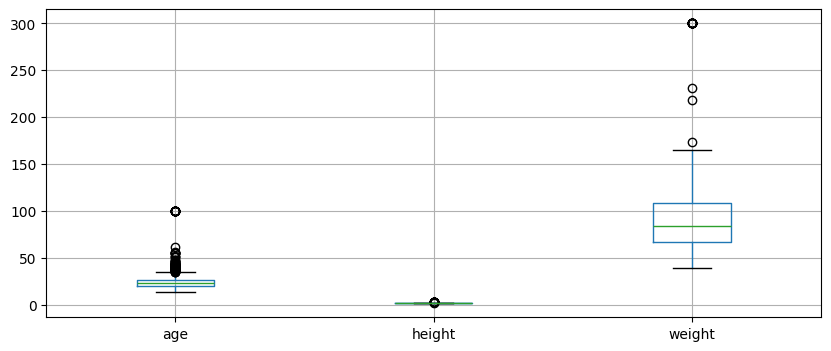

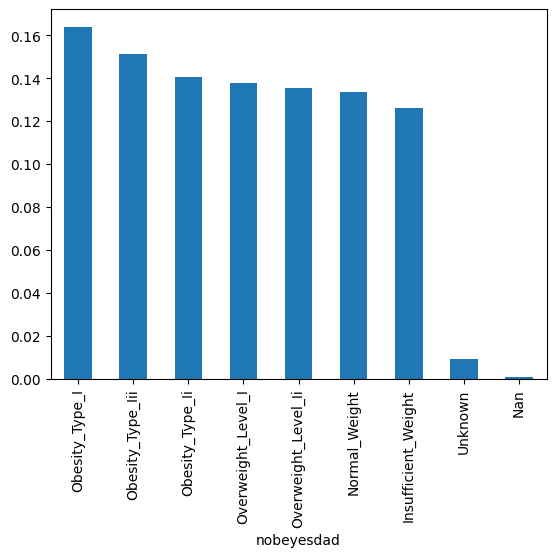

In [46]:
import matplotlib.pyplot as plt
df.describe().T  # tabla
df[['age','height','weight','fcvc','ncp','ch2o','faf','tue']].hist(bins=20, figsize=(12,8)); plt.show()
df.boxplot(column=['age','height','weight'], figsize=(10,4)); plt.show()
df['nobeyesdad'].value_counts(normalize=True).plot(kind='bar'); plt.show()




In [47]:
from google.colab import files

# Descargar cada archivo
files.download("data_outputs/obesity_clean.csv")
files.download("data_outputs/obesity_ml_ready.csv")
files.download("data_outputs/label_map_nobeyesdad.csv")
files.download("data_outputs/obesity_data_dictionary.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>